In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt


timeseries_folder="../data/timeseries"
# name = "16285738312.csv" # seuil 5x5'
name = "16262137158.csv" # sl 2 alpes
name = "16251238864.csv" # côte rapide pisse
name = "16235724470.csv" # VMA
name = "16285738312.csv" # seuil 5x5'


df = pd.read_csv(os.path.join(timeseries_folder, name))
df = df.iloc[500:2700]
df.head()





,timestamp,hr,paceKmh,elevationM,cadence,lat,lon
500,2025-10-28T19:37:01+00:00,164,9.720,224.2,86,45.186637,5.787128
501,2025-10-28T19:37:02+00:00,164,9.864,224.0,86,45.186665,5.787107
502,2025-10-28T19:37:03+00:00,163,10.080,224.0,86,45.186690,5.787097
503,2025-10-28T19:37:04+00:00,163,10.440,223.8,86,45.186720,5.787089
504,2025-10-28T19:37:05+00:00,163,10.944,223.8,87,45.186746,5.787080


In [15]:
from haversine import haversine
import numpy as np
def distance(df, lat_col="lat", lon_col="lon"):
    """
    Compute the distance between 2 consecutives row based on the latitude and longitude for all the rows.
    Create a new column with the distance.
    """
    # Compute pairwise distances row-by-row
    df['distance'] = [
        haversine((lat1, lon1), (lat2, lon2))
        for lat1, lon1, lat2, lon2 in zip(
            df[lat_col].shift(),
            df[lon_col].shift(),
            df[lat_col],
            df[lon_col]
        )
    ]
    # df['distance'] = df['distance'].fillna(0)
    return df

def cumulated_distance(df, distance_col="distance"):
    """
    Compute the cumulated distance of the dataframe based on the distance column.
    Create a new column with the cumulated distance.
    """
    df['cumulated_distance'] = df[distance_col].cumsum()
    return df
def time_from_timestamp(df, timestamp_col="timestamp"):
    """
    Convert the timestamp column to a datetime object.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df['time'] = df[timestamp_col].dt.time
    return df
def duration(df, timestamp_col="timestamp"):
    """
    Compute the duration of the dataframe based on the timestamp column.
    Create a new column with the duration.
    """
    df['duration'] = df[timestamp_col].diff().fillna(pd.Timedelta(seconds=0))
    df['cumulated_duration'] = df['duration'].cumsum()
    df['duration_seconds'] = df['duration'].dt.total_seconds()
    df['cumulated_duration_seconds'] = df['duration_seconds'].cumsum()
    # df = df.drop(columns=['duration'])
    return df

def speed(df, distance_col="distance", time_col="duration_seconds"):
    """
    Compute the speed of the dataframe based on the distance and time columns.
    Create a new column with the speed.
    """
    print("Nan or 0 values in time_col: ", df[time_col].isna().sum(), (df[time_col] == 0).sum())

    # Replace 0 values in time_col with the mean of non-zero values
    mean_time = df.loc[df[time_col] > 0, time_col].mean().round(1)
    print("Setting 0 values in time_col to the mean of non-zero values: ", mean_time)
    df[time_col] = df[time_col].replace(0, mean_time)
    df['speed_m_s'] = 1000*df[distance_col] / df[time_col]
    df['speed_km_h'] = 3.6*df['speed_m_s']

    return df

def elevation(df, elevation_col="elevationM"):
    """
    Compute the elevation difference of the dataframe based on the elevation column.
    Create a new column with the elevation difference.
    """
    df['elevation_difference'] = df[elevation_col].diff().fillna(0)
    df['elevation_cumulated'] = df['elevation_difference'].cumsum()
    df['elevation_gain'] = df['elevation_difference'].apply(lambda x: x if x > 0 else 0).cumsum()
    df['elevation_loss'] = df['elevation_difference'].apply(lambda x: -x if x < 0 else 0).cumsum()
    return df

def grade(df, distance_col="distance", elevation_col="elevation_difference"):
    """
    Compute the grade of the dataframe based on the distance and elevation columns.
    Create a new column with the grade.
    """
    df['grade'] = df[elevation_col] / df[distance_col]*1000
    df['grade'] = df['grade'].replace(np.inf, 0)
    df['grade'] = df['grade'].replace(-np.inf, 0)

    df['grade'] = df['grade'].replace(np.nan, 0)
    df['grade'] = df['grade'].fillna(0)

    return df
def moving_average(df, window_size=5, col="distance"):
    """
    Compute the moving average of the distance column over a specified window size.
    Create a new column with the moving average distance.
    """
    df[f'{col}_ma_{window_size}'] = df[col].rolling(window=window_size,min_periods=1, center=True).mean()
    return df

def hist(df, col="grade"):
# Compute histogram as a table
    hist, bins = pd.cut(df[col], bins=10, retbins=True)
    hist_table = hist.value_counts().sort_index().reset_index()
    hist_table.columns = [f"{col}_Bin", "Frequency"]
    return hist_table


# ids =[9033,9034,9035,9036,9037]
# for id_val in ids:
#     print(f"Processing ID: {id_val}")
#     print(df.iloc[id_val])


df = moving_average(df, window_size=5, col="lat")
df = moving_average(df, window_size=5, col="lon")
df = distance(df, lat_col="lat_ma_5", lon_col="lon_ma_5")
# Get rows where distance is 0
df = elevation(df)


print("Number of rows before filtering: ", len(df))
print("Percentage of rows removed: ", (len(df) - len(df[df['distance'] > 1e-5])) / len(df) * 100," %")
df =df[df['distance'] > 1e-5].reset_index(drop=True)
print("Number of rows after filtering: ", len(df))
df['distance'] = df['distance'].interpolate(method='linear')

df = time_from_timestamp(df)
df = duration(df)
# Get value counts of duration_seconds
duration_counts = df['duration_seconds'].value_counts().sort_index()
print("Value counts of duration_seconds:")
print(duration_counts)




df = cumulated_distance(df)
df = moving_average(df, window_size=30, col="distance")
df = speed(df, distance_col="distance", time_col="duration_seconds")

# Get rows where speed < 40
df = df[df['speed_km_h'] < 40]



df = grade(df, distance_col="distance_ma_30", elevation_col="elevation_difference")
print(df.head(-5))

hist_table = hist(df, col="duration_seconds")
# Display the histogram table
print(hist_table)


# Compare paceKmh vs speed_km_h






Number of rows before filtering:  2200
Percentage of rows removed:  0.6818181818181818  %
Number of rows after filtering:  2185
Value counts of duration_seconds:
duration_seconds
0.0        1
1.0     2182
2.0        1
14.0       1
Name: count, dtype: int64
Nan or 0 values in time_col:  0 1
Setting 0 values in time_col to the mean of non-zero values:  1.0
                     timestamp   hr  paceKmh  elevationM  cadence        lat  \
0    2025-10-28 19:37:02+00:00  164    9.864       224.0       86  45.186665   
1    2025-10-28 19:37:03+00:00  163   10.080       224.0       86  45.186690   
2    2025-10-28 19:37:04+00:00  163   10.440       223.8       86  45.186720   
3    2025-10-28 19:37:05+00:00  163   10.944       223.8       87  45.186746   
4    2025-10-28 19:37:06+00:00  162   11.736       223.6       88  45.186776   
...                        ...  ...      ...         ...      ...        ...   
2175 2025-10-28 20:13:31+00:00  188   15.192       199.4       87  45.187409   
217

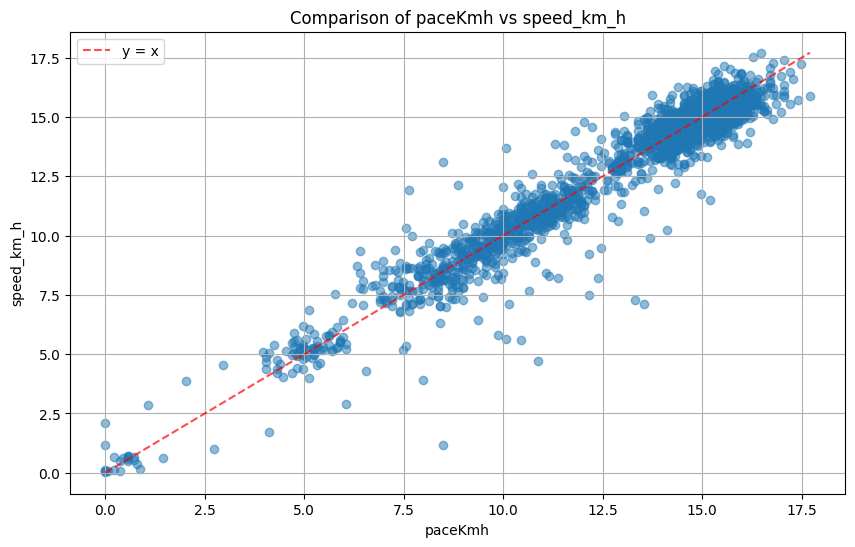

           paceKmh   speed_km_h
count  2185.000000  2185.000000
mean     12.893009    12.848751
std       3.170876     3.176866
min       0.000000     0.017156
25%      10.800000    10.783445
50%      14.328000    14.299260
75%      15.120000    15.090166
max      17.712000    17.695609
Correlation between paceKmh and speed_km_h: 0.9673


In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df['paceKmh'], df['speed_km_h'], alpha=0.5)
plt.xlabel('paceKmh')
plt.ylabel('speed_km_h')
plt.title('Comparison of paceKmh vs speed_km_h')
plt.grid(True)

# Add a diagonal line for reference (y = x)
min_val = min(df['paceKmh'].min(), df['speed_km_h'].min())
max_val = max(df['paceKmh'].max(), df['speed_km_h'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='y = x')

plt.legend()
plt.show()

# Compute correlation
print(df[['paceKmh','speed_km_h']].describe())
correlation = df['paceKmh'].corr(df['speed_km_h'])
print(f"Correlation between paceKmh and speed_km_h: {correlation:.4f}")

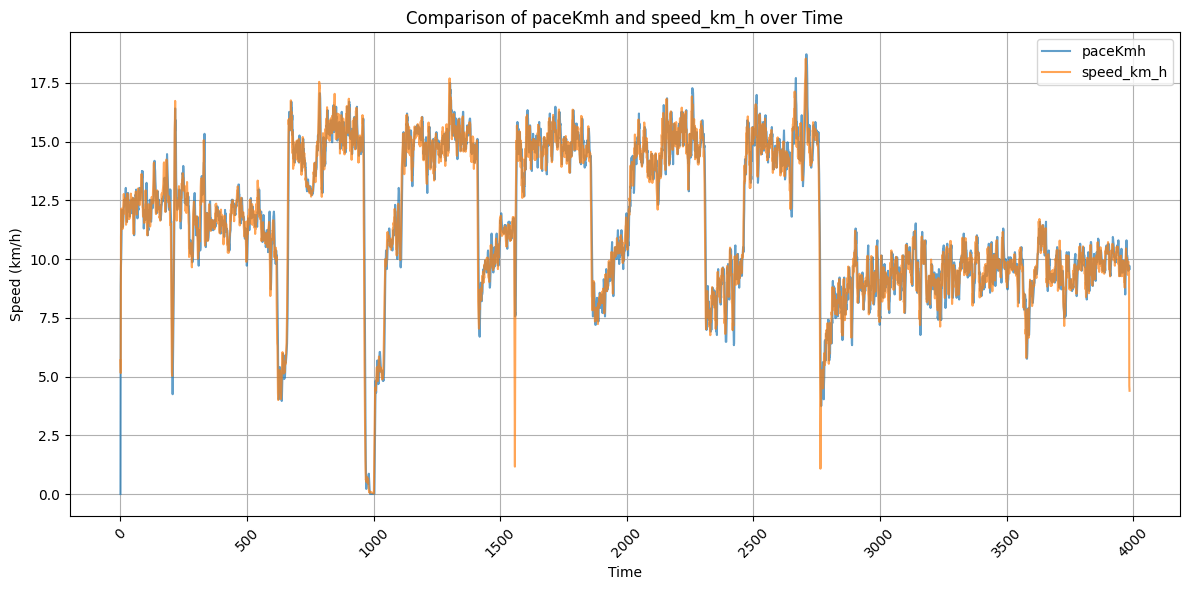

In [4]:
# Plot paceKmh and speed_km_h over time for comparison
plt.figure(figsize=(12, 6))
plt.plot(df['cumulated_duration_seconds'], df['paceKmh'], label='paceKmh', alpha=0.7)
plt.plot(df['cumulated_duration_seconds'], df['speed_km_h'], label='speed_km_h', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Speed (km/h)')
plt.title('Comparison of paceKmh and speed_km_h over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Best correlation: 0.8434 at offset: -35
Original correlation: 0.5694


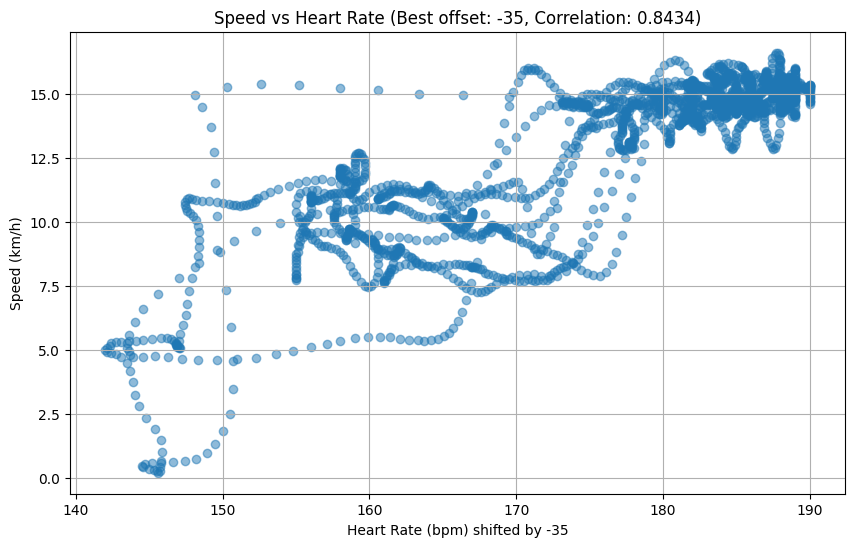

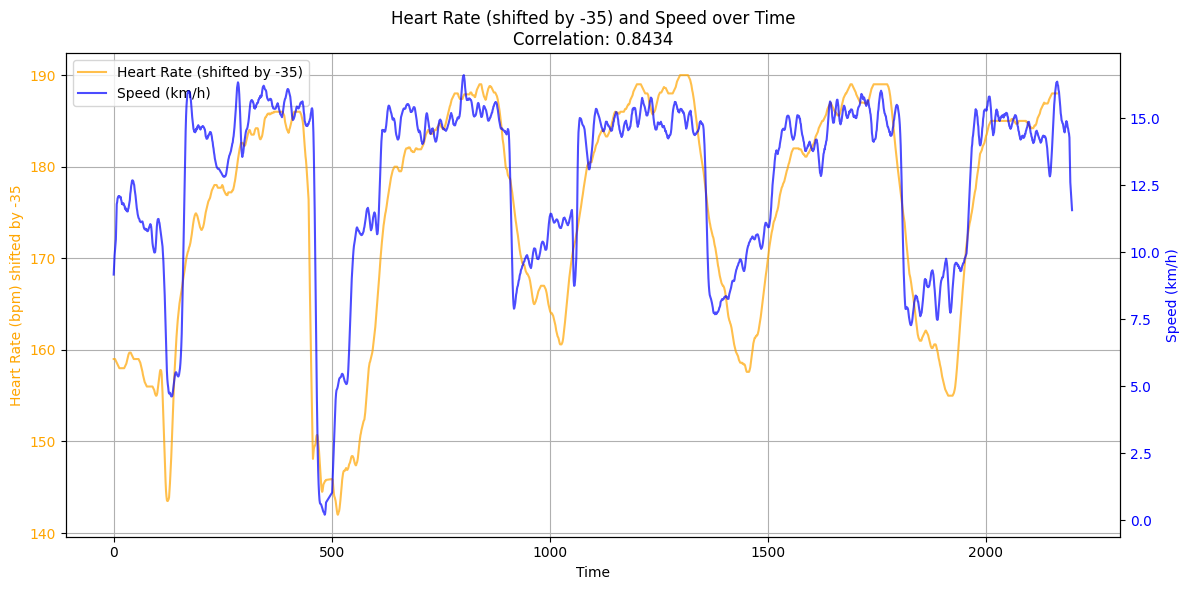

In [17]:
# Compute correlation between speed_km_h and hr with offset optimization

df = df[df['hr'] > 120].copy()

df = moving_average(df, window_size=10, col="hr")
df = moving_average(df, window_size=10, col="speed_km_h")
#rename the columns
df.rename(columns={"hr_ma_10":"hr_smooth", "speed_km_h_ma_10":"speed_smooth"}, inplace=True)
hr_col="hr_smooth"
col="speed_smooth"

# CORRELATION COMPUTATION: Find best offset for correlation
best_correlation = 0
best_offset = 0
correlations = []

for offset in range(-60, 60):
    # Shift heart rate data by offset
    shifted_hr = df[hr_col].shift(offset)
    # CORRELATION COMPUTATION: Calculate correlation with non-null values only using pd.corr
    valid_data = pd.concat([df[col], shifted_hr], axis=1).dropna()
    if len(valid_data) > 0:
        correlation = valid_data.corr().iloc[0, 1]
        correlations.append((offset, correlation))
        if abs(correlation) > abs(best_correlation):
            best_correlation = correlation
            best_offset = offset
    else:
        print(f"No valid data for offset {offset}")

print(f"Best correlation: {best_correlation:.4f} at offset: {best_offset}")

# CORRELATION COMPUTATION: Calculate original correlation safely using pd.corr
original_corr_data = pd.concat([df[col], df[hr_col]], axis=1).dropna()
if len(original_corr_data) > 0:
    original_correlation = original_corr_data.corr().iloc[0, 1]
    print(f"Original correlation: {original_correlation:.4f}")
else:
    print("Original correlation: No valid data for correlation calculation")

# Apply best offset
df['hr_shifted'] = df[hr_col].shift(best_offset)

# Scatter plot with best offset
plt.figure(figsize=(10, 6))
plt.scatter(df['hr_shifted'], df[col], alpha=0.5)
plt.xlabel(f'Heart Rate (bpm) shifted by {best_offset}')
plt.ylabel('Speed (km/h)')
plt.title(f'Speed vs Heart Rate (Best offset: {best_offset}, Correlation: {best_correlation:.4f})')
plt.grid(True)
plt.show()

# Plot hr (with best offset) and speed_km_h over time for comparison with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot shifted heart rate on left y-axis
ax1.plot(df['cumulated_duration_seconds'], df['hr_shifted'], label=f'Heart Rate (shifted by {best_offset})', alpha=0.7, color='orange')
ax1.set_xlabel('Time')
ax1.set_ylabel(f'Heart Rate (bpm) shifted by {best_offset}', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.grid(True)

# Create second y-axis for speed
ax2 = ax1.twinx()
ax2.plot(df['cumulated_duration_seconds'], df[col], label='Speed (km/h)', alpha=0.7, color='blue')
ax2.set_ylabel('Speed (km/h)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title(f'Heart Rate (shifted by {best_offset}) and Speed over Time\nCorrelation: {best_correlation:.4f}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


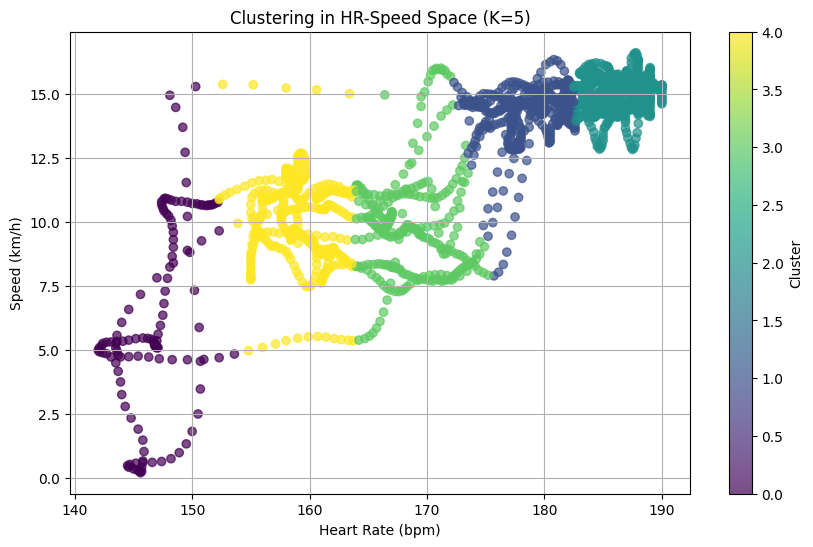


Cluster Statistics (K=5):
Cluster 0:
  Size: 127 points
  Mean HR: 147.1 bpm
  Mean Speed: 6.3 km/h
  HR Range: 142.0 - 153.6 bpm
  Speed Range: 0.2 - 15.3 km/h
  Std HR: 2.7 bpm
  Std Speed: 3.7 km/h

Cluster 1:
  Size: 466 points
  Mean HR: 178.8 bpm
  Mean Speed: 14.3 km/h
  HR Range: 172.3 - 182.6 bpm
  Speed Range: 7.9 - 16.3 km/h
  Std HR: 2.8 bpm
  Std Speed: 1.1 km/h

Cluster 2:
  Size: 907 points
  Mean HR: 186.3 bpm
  Mean Speed: 15.0 km/h
  HR Range: 182.5 - 190.0 bpm
  Speed Range: 12.8 - 16.6 km/h
  Std HR: 1.9 bpm
  Std Speed: 0.6 km/h

Cluster 3:
  Size: 281 points
  Mean HR: 168.6 bpm
  Mean Speed: 9.9 km/h
  HR Range: 163.9 - 175.2 bpm
  Speed Range: 5.4 - 16.0 km/h
  Std HR: 2.9 bpm
  Std Speed: 2.1 km/h

Cluster 4:
  Size: 369 points
  Mean HR: 159.0 bpm
  Mean Speed: 10.1 km/h
  HR Range: 152.3 - 163.8 bpm
  Speed Range: 5.0 - 15.4 km/h
  Std HR: 2.5 bpm
  Std Speed: 1.6 km/h



/tmp/ipykernel_1907145/3978320693.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


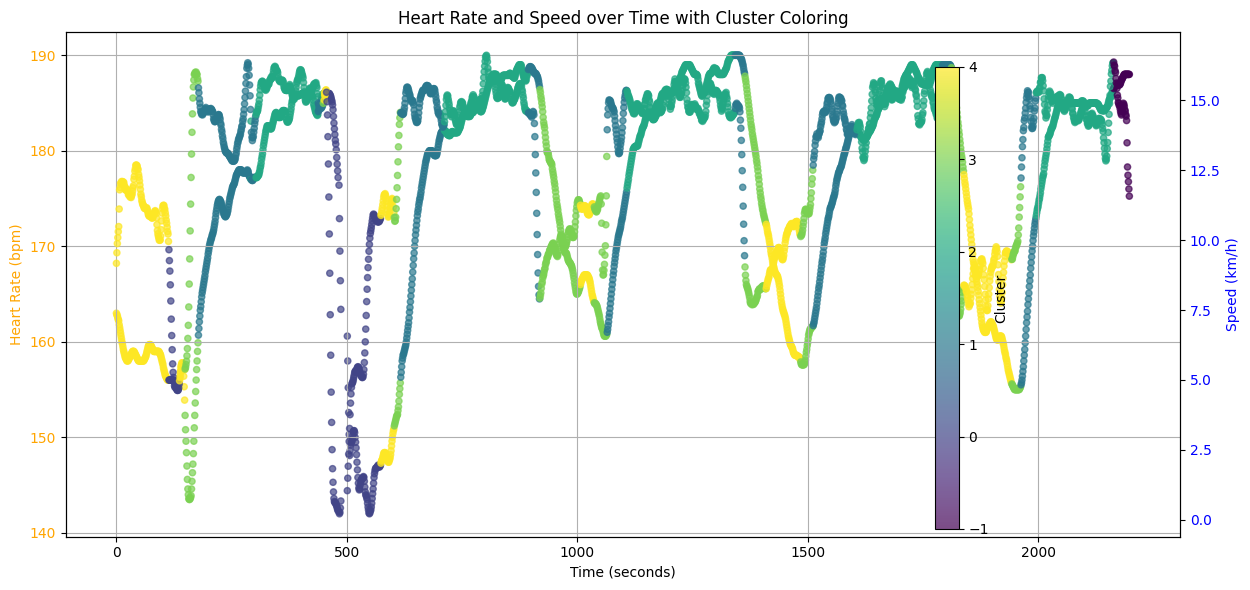

In [19]:
# Compute clusters in the hr, speed space using KMeans
from sklearn.cluster import KMeans

elbow=False
hr_col="hr_shifted"
X = df[[hr_col, col]].dropna()
if elbow:
    # Use elbow method to determine optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Plot elbow method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal Clusters')
    plt.grid(True)
    plt.show()

# Based on elbow method, choose optimal number of clusters (typically 2-3 for this type of data)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataframe
df_clustered = X.copy()
df_clustered['cluster'] = clusters

# Plot clustered data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_clustered[hr_col], df_clustered[col], 
                     c=df_clustered['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Speed (km/h)')
plt.title(f'Clustering in HR-Speed Space (K={n_clusters})')
plt.grid(True)
plt.show()

# Print cluster statistics
print(f"\nCluster Statistics (K={n_clusters}):")
for cluster_id in range(n_clusters):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(f"  Size: {len(cluster_data)} points")
    print(f"  Mean HR: {cluster_data[hr_col].mean():.1f} bpm")
    print(f"  Mean Speed: {cluster_data[col].mean():.1f} km/h")
    print(f"  HR Range: {cluster_data[hr_col].min():.1f} - {cluster_data[hr_col].max():.1f} bpm")
    print(f"  Speed Range: {cluster_data[col].min():.1f} - {cluster_data[col].max():.1f} km/h")
    print(f"  Std HR: {cluster_data[hr_col].std():.1f} bpm")
    print(f"  Std Speed: {cluster_data[col].std():.1f} km/h")
    print()

# Add cluster information to original dataframe for time series plotting
df_with_clusters = df.copy()
df_with_clusters['cluster'] = df_with_clusters.index.map(lambda idx: clusters[df_with_clusters.index.get_indexer([idx])[0]] 
                                                         if idx in X.index else -1)

# Plot hr and speed_km_h over time with cluster coloring using dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot heart rate on left y-axis with cluster coloring
scatter1 = ax1.scatter(df_with_clusters['cumulated_duration_seconds'], df_with_clusters["hr_smooth"], 
                      c=df_with_clusters['cluster'], cmap='viridis', alpha=0.7, s=20)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Heart Rate (bpm)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.grid(True)

# Create second y-axis for speed
ax2 = ax1.twinx()
scatter2 = ax2.scatter(df_with_clusters['cumulated_duration_seconds'], df_with_clusters[col], 
                      c=df_with_clusters['cluster'], cmap='viridis', alpha=0.7, s=20)
ax2.set_ylabel('Speed (km/h)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add colorbar for clusters
cbar = plt.colorbar(scatter1, ax=[ax1, ax2])
cbar.set_label('Cluster')

plt.title('Heart Rate and Speed over Time with Cluster Coloring')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


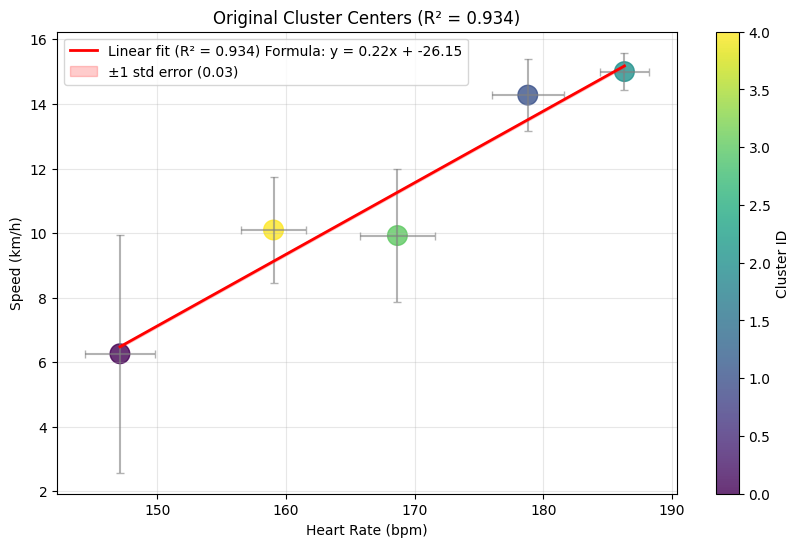

Original R value (0.966) is >= 0.9, keeping all clusters


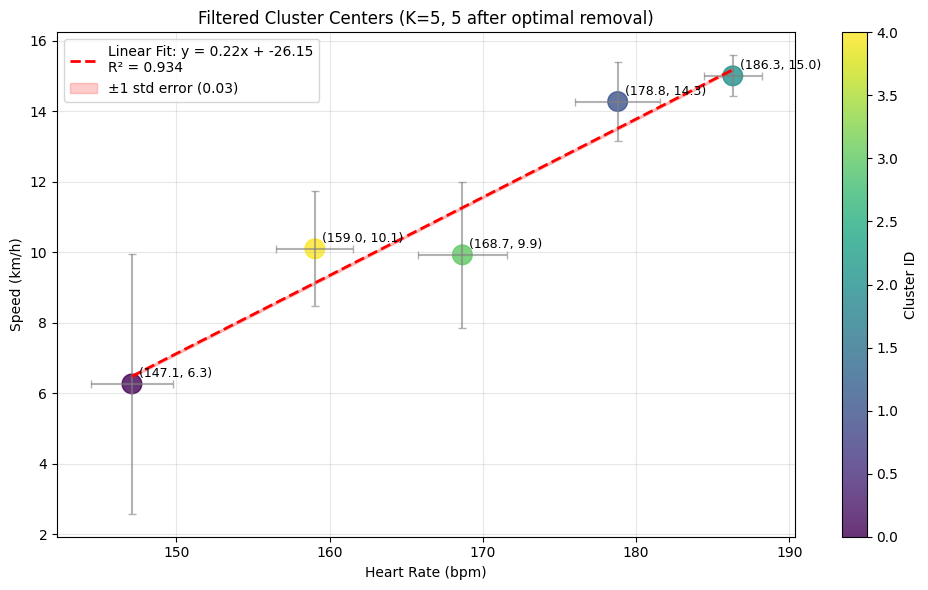


Filtered Cluster Centers (K=5, 5 after optimal removal):
Cluster 0: HR=147.1 bpm, Speed=6.3 km/h
Cluster 1: HR=178.8 bpm, Speed=14.3 km/h
Cluster 2: HR=186.3 bpm, Speed=15.0 km/h
Cluster 3: HR=168.7 bpm, Speed=9.9 km/h
Cluster 4: HR=159.0 bpm, Speed=10.1 km/h
Heart Rate: 140 bpm, Speed: 4.9 km/h
Heart Rate: 150 bpm, Speed: 7.1 km/h
Heart Rate: 160 bpm, Speed: 9.3 km/h
Heart Rate: 170 bpm, Speed: 11.6 km/h
Heart Rate: 180 bpm, Speed: 13.8 km/h
Heart Rate: 185 bpm, Speed: 14.9 km/h
Heart Rate: 190 bpm, Speed: 16.0 km/h
Heart Rate: 195 bpm, Speed: 17.1 km/h
Heart Rate: 200 bpm, Speed: 18.2 km/h


In [20]:
import scipy.stats as stats
from scipy import stats as scipy_stats
import itertools

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate cluster standard deviations for mustaches
cluster_hr_stds = []
cluster_speed_stds = []
for cluster_id in range(n_clusters):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    cluster_hr_stds.append(cluster_data[hr_col].std())
    cluster_speed_stds.append(cluster_data[col].std())

# lin reg with all clusters
slope, intercept, original_r_value, p_value, std_err = stats.linregress(cluster_centers[:, 0], cluster_centers[:, 1])
# Plot original cluster centers and linear regression
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                     c=np.arange(len(cluster_centers)), cmap='viridis', s=200, alpha=0.8)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Speed (km/h)')

# Add mustaches for cluster centers based on cluster std
for i, center in enumerate(cluster_centers):
    hr_std = cluster_hr_stds[i]
    speed_std = cluster_speed_stds[i]
    plt.errorbar(center[0], center[1], 
                xerr=hr_std, yerr=speed_std,
                fmt='none', ecolor='gray', alpha=0.6, capsize=3, capthick=1)

# Plot linear regression line with std mustache
x_range = np.linspace(cluster_centers[:, 0].min(), cluster_centers[:, 0].max(), 100)
y_pred = slope * x_range + intercept
plt.plot(x_range, y_pred, 'r-', linewidth=2, 
label=f'Linear fit (R² = {original_r_value**2:.3f}) Formula: y = {slope:.2f}x + {intercept:.2f}')

# Add std mustache (confidence interval)
y_upper = y_pred + std_err
y_lower = y_pred - std_err
plt.fill_between(x_range, y_lower, y_upper, color='red', alpha=0.2, label=f'±1 std error ({std_err:.2f})')

plt.title(f'Original Cluster Centers (R² = {original_r_value**2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Only perform cluster removal if original R value is lower than threshold (0.9)
if original_r_value < 0.95 and len(cluster_centers) > 1:
    n_centers = len(cluster_centers)
    remove_count = max(1, int(n_centers * 0.2))  # Remove approximately 20% of clusters
    
    best_r_squared = -1
    best_combination = None
    best_filtered_centers = None
    
    # Generate all combinations of clusters to remove
    for clusters_to_remove in itertools.combinations(range(n_centers), remove_count):
        keep_mask = np.ones(n_centers, dtype=bool)
        keep_mask[list(clusters_to_remove)] = False
        
        current_centers = cluster_centers[keep_mask]
        x_centers = current_centers[:, 0]
        y_centers = current_centers[:, 1]
        
        if len(current_centers) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_centers, y_centers)
            current_r_squared = r_value**2
            
            if current_r_squared > best_r_squared:
                best_r_squared = current_r_squared
                best_combination = clusters_to_remove
                best_filtered_centers = current_centers
                best_keep_mask = keep_mask
    
    if best_filtered_centers is not None:
        filtered_centers = best_filtered_centers
        filtered_cluster_ids = np.arange(n_clusters)[best_keep_mask]
        print(f"Removed clusters {list[int](best_combination)} to improve R² from {original_r_value**2:.3f} to {best_r_squared:.3f}")
    else:
        # Fallback: keep all clusters if no improvement found
        filtered_centers = cluster_centers
        filtered_cluster_ids = np.arange(n_clusters)
else:
    # If original R value is >= 0.9 or only one cluster center, keep all clusters
    filtered_centers = cluster_centers
    filtered_cluster_ids = np.arange(n_clusters)
    if len(cluster_centers) > 1 and original_r_value >= 0.9:
        print(f"Original R value ({original_r_value:.3f}) is >= 0.9, keeping all clusters")

# Plot filtered cluster centers
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_centers[:, 0], filtered_centers[:, 1], 
                     c=filtered_cluster_ids, cmap='viridis', s=200, alpha=0.8)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Speed (km/h)')
plt.title(f'Filtered Cluster Centers (K={n_clusters}, {len(filtered_centers)} after optimal removal)')

# Add mustaches for filtered cluster centers based on cluster std
for i, center in enumerate(filtered_centers):
    cluster_id = filtered_cluster_ids[i]
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    hr_std = cluster_data[hr_col].std()
    speed_std = cluster_data[col].std()
    plt.errorbar(center[0], center[1], 
                xerr=hr_std, yerr=speed_std,
                fmt='none', ecolor='gray', alpha=0.6, capsize=3, capthick=1)

# Annotate each filtered cluster center with its coordinates
for i, center in enumerate(filtered_centers):
    plt.annotate(f'({center[0]:.1f}, {center[1]:.1f})', 
                (center[0], center[1]), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9)

# Add linear regression based on filtered cluster centers with std mustache
if len(filtered_centers) > 1:
    x_centers = filtered_centers[:, 0]
    y_centers = filtered_centers[:, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_centers, y_centers)
    x_range = np.linspace(min(x_centers), max(x_centers), 100)
    y_pred = slope * x_range + intercept
    plt.plot(x_range, y_pred, 'r--', linewidth=2, 
             label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.3f}')
    
    # Add std mustache (confidence interval)
    y_upper = y_pred + std_err
    y_lower = y_pred - std_err
    plt.fill_between(x_range, y_lower, y_upper, color='red', alpha=0.2, label=f'±1 std error ({std_err:.2f})')
    
    plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print filtered cluster centers
print(f"\nFiltered Cluster Centers (K={n_clusters}, {len(filtered_centers)} after optimal removal):")
for i, center in enumerate(filtered_centers):
    cluster_id = filtered_cluster_ids[i]
    print(f"Cluster {cluster_id}: HR={center[0]:.1f} bpm, Speed={center[1]:.1f} km/h")

hr_list= [140,150,160,170,180,185,190,195,200]
for hr in hr_list:
    speed = slope * hr + intercept
    print(f"Heart Rate: {hr} bpm, Speed: {speed:.1f} km/h")


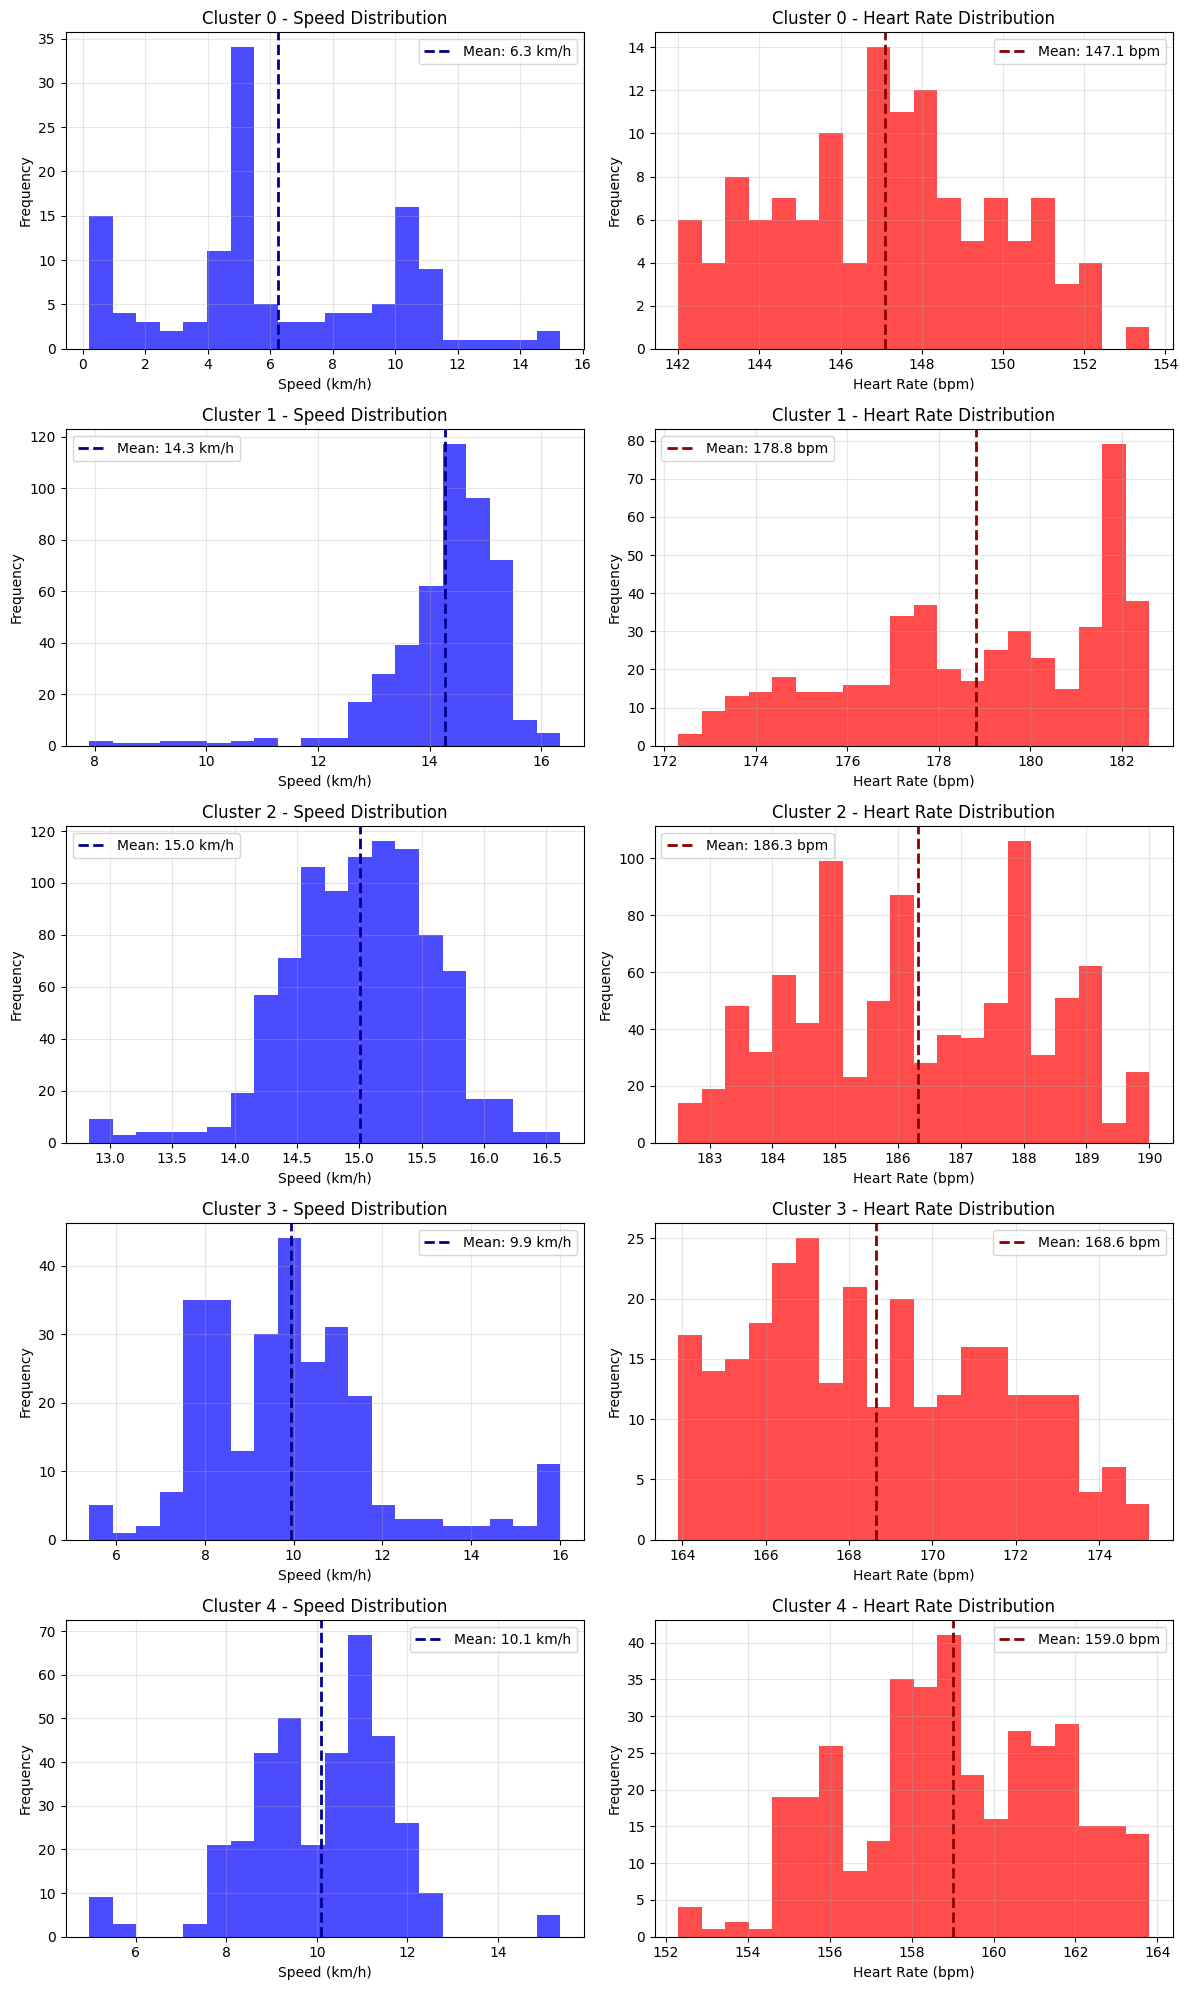

In [21]:
# Plot histograms for each cluster
fig, axes = plt.subplots(n_clusters, 2, figsize=(12, 4*n_clusters))

for cluster_id in range(n_clusters):
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    # Speed histogram
    speed_mean = cluster_data[col].mean()
    axes[cluster_id, 0].hist(cluster_data[col], bins=20, alpha=0.7, color='blue')
    axes[cluster_id, 0].axvline(speed_mean, color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {speed_mean:.1f} km/h')
    axes[cluster_id, 0].set_xlabel('Speed (km/h)')
    axes[cluster_id, 0].set_ylabel('Frequency')
    axes[cluster_id, 0].set_title(f'Cluster {cluster_id} - Speed Distribution')
    axes[cluster_id, 0].grid(True, alpha=0.3)
    axes[cluster_id, 0].legend()
    
    # Heart rate histogram
    hr_mean = cluster_data[hr_col].mean()
    axes[cluster_id, 1].hist(cluster_data[hr_col], bins=20, alpha=0.7, color='red')
    axes[cluster_id, 1].axvline(hr_mean, color='darkred', linestyle='--', linewidth=2, label=f'Mean: {hr_mean:.1f} bpm')
    axes[cluster_id, 1].set_xlabel('Heart Rate (bpm)')
    axes[cluster_id, 1].set_ylabel('Frequency')
    axes[cluster_id, 1].set_title(f'Cluster {cluster_id} - Heart Rate Distribution')
    axes[cluster_id, 1].grid(True, alpha=0.3)
    axes[cluster_id, 1].legend()

plt.tight_layout()
plt.show()



Correlation between speed_smooth and hr_shifted for each cluster:
Cluster 0: Correlation = 0.489
Cluster 1: Correlation = 0.278
Cluster 2: Correlation = 0.165
Cluster 3: Correlation = 0.091
Cluster 4: Correlation = -0.148


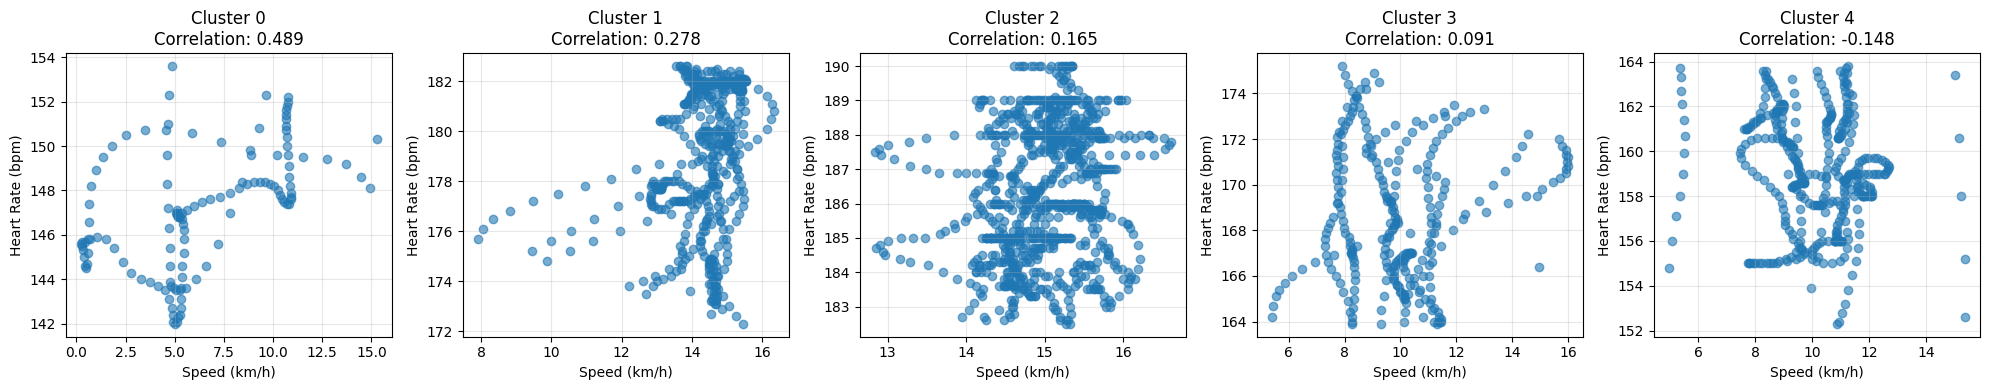

In [22]:
# Compute correlation between speed and heart rate for each cluster
print(f"\nCorrelation between {col} and {hr_col} for each cluster:")
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4))
if n_clusters == 1:
    axes = [axes]

for cluster_id in range(n_clusters):
    cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    correlation = cluster_data[col].corr(cluster_data[hr_col])
    print(f"Cluster {cluster_id}: Correlation = {correlation:.3f}")
    
    # Plot scatter plot for correlation visualization
    axes[cluster_id].scatter(cluster_data[col], cluster_data[hr_col], alpha=0.6)
    axes[cluster_id].set_xlabel('Speed (km/h)')
    axes[cluster_id].set_ylabel('Heart Rate (bpm)')
    axes[cluster_id].set_title(f'Cluster {cluster_id}\nCorrelation: {correlation:.3f}')
    axes[cluster_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Max average speed for different window sizes:
Window size 15s: Max average speed_km_h = 16.2
Window size 15s: Average hr around max speed position = 187.8
Window size 20s: Max average speed_km_h = 16.2
Window size 20s: Average hr around max speed position = 187.9
Window size 30s: Max average speed_km_h = 15.9
Window size 30s: Average hr around max speed position = 187.8
Window size 60s: Max average speed_km_h = 15.7
Window size 60s: Average hr around max speed position = 184.7
Window size 120s: Max average speed_km_h = 15.6
Window size 120s: Average hr around max speed position = 185.1
Window size 180s: Max average speed_km_h = 15.4
Window size 180s: Average hr around max speed position = 181.9
Window size 240s: Max average speed_km_h = 15.1
Window size 240s: Average hr around max speed position = 185.3
Window size 300s: Max average speed_km_h = 15.0
Window size 300s: Average hr around max speed position = 183.8
Window size 360s: Max average speed_km_h = 14.7
Window size 360s: Average 

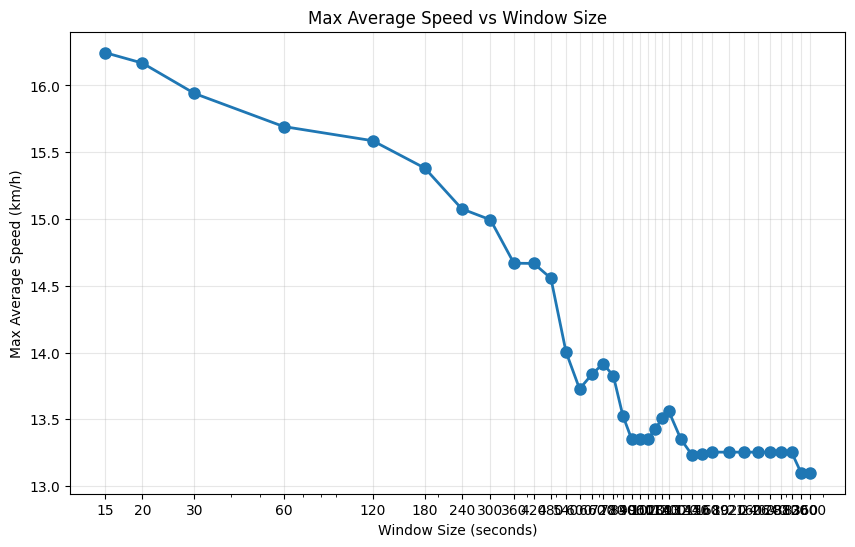

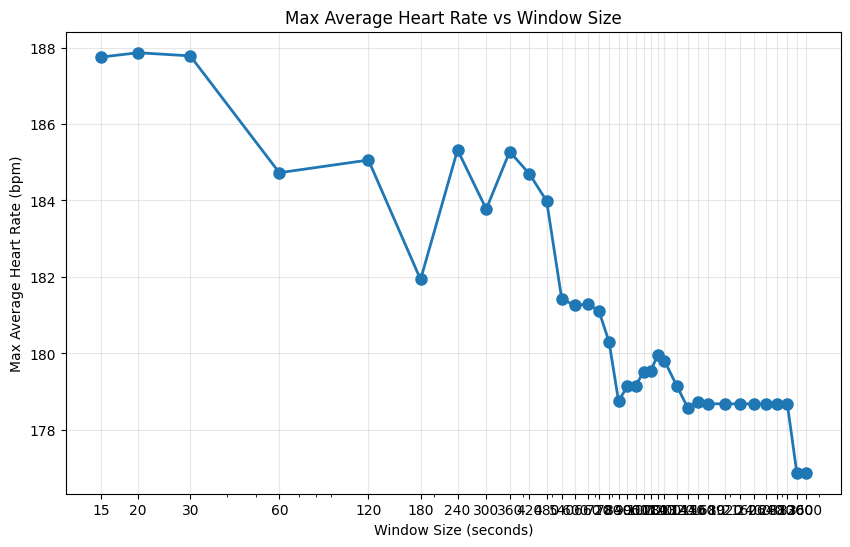

In [23]:
# Compute max average speed over different window sizes
def compute_profile(df, col,additional_col=None, window_sizes=[5, 10, 15, 20, 30, 60]):
    """
    Compute the speed profile by calculating max average speeds for different window sizes.
    
    Parameters:
    df (DataFrame): The input dataframe containing speed data
    speed_col (str): The column name containing speed values
    window_sizes (list): List of window sizes in seconds for rolling average
    
    Returns:
    dict: Dictionary with window sizes as keys and max average speeds as values
    """
    max_avg_speeds = {}
    max_avg_additional_values = {}
    
    print("Max average speed for different window sizes:")
    for window_size in window_sizes:
        # Calculate rolling average speed for the specified window
        rolling_avg = df[col].rolling(window=window_size,min_periods=1,center=True).mean()
        max_avg = rolling_avg.max()
        max_avg_idx = rolling_avg.idxmax()-best_offset
        max_avg_speeds[window_size] = max_avg
        print(f"Window size {window_size}s: Max average {col} = {max_avg:.1f}")
        
        # If additional_col is provided, calculate and print its values at the same position as max_avg_speed
        if additional_col is not None:
            # Calculate the average of additional_col over the window_size centered on max_avg_idx
            if pd.notna(max_avg_idx):
                half_window = window_size // 2
                start_idx = max(0, max_avg_idx - half_window)
                end_idx = min(len(df), max_avg_idx + half_window + 1)
                additional_avg = df.loc[start_idx:end_idx, additional_col].mean()
            else:
                additional_avg = None
            max_avg_additional_values[window_size] = additional_avg
            print(f"Window size {window_size}s: Average {additional_col} around max speed position = {additional_avg:.1f}")
    return max_avg_speeds,max_avg_additional_values
window_sizes = [15, 20, 30, 60,120,180,240,300,360,420,480,540,600,660,720,780,840,900,960,1020,
                1080,1140,1200,1320,1440,1560,1680,1920,2160,2400,2640,2880,3120,3360,3600]  # window sizes in seconds
# Compute the speed profile
max_avg_speeds,max_avg_additional_values = compute_profile(df_with_clusters, "speed_km_h", "hr", window_sizes)

# Optional: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(list(max_avg_speeds.keys()), list(max_avg_speeds.values()), 'o-', linewidth=2, markersize=8)
plt.xlabel('Window Size (seconds)')
plt.ylabel('Max Average Speed (km/h)')
plt.title('Max Average Speed vs Window Size')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.xticks(window_sizes, labels=window_sizes)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(list(max_avg_speeds.keys()), list(max_avg_additional_values.values()), 'o-', linewidth=2, markersize=8)
plt.xlabel('Window Size (seconds)')
plt.ylabel('Max Average Heart Rate (bpm)')
plt.title('Max Average Heart Rate vs Window Size')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.xticks(window_sizes, labels=window_sizes)
plt.show()




Max average speed for different window sizes:
Window size 15s: Max average hr = 190.0
Window size 20s: Max average hr = 190.0
Window size 30s: Max average hr = 189.9
Window size 60s: Max average hr = 189.1
Window size 120s: Max average hr = 188.4
Window size 180s: Max average hr = 188.0
Window size 240s: Max average hr = 187.0
Window size 300s: Max average hr = 185.5
Window size 360s: Max average hr = 185.1
Window size 420s: Max average hr = 183.7
Window size 480s: Max average hr = 180.9
Window size 540s: Max average hr = 180.8
Window size 600s: Max average hr = 181.3
Window size 660s: Max average hr = 181.4
Window size 720s: Max average hr = 181.3
Window size 780s: Max average hr = 180.7
Window size 840s: Max average hr = 179.5
Window size 900s: Max average hr = 179.3
Window size 960s: Max average hr = 179.3
Window size 1020s: Max average hr = 179.6
Window size 1080s: Max average hr = 179.9
Window size 1140s: Max average hr = 180.0
Window size 1200s: Max average hr = 179.8
Window size

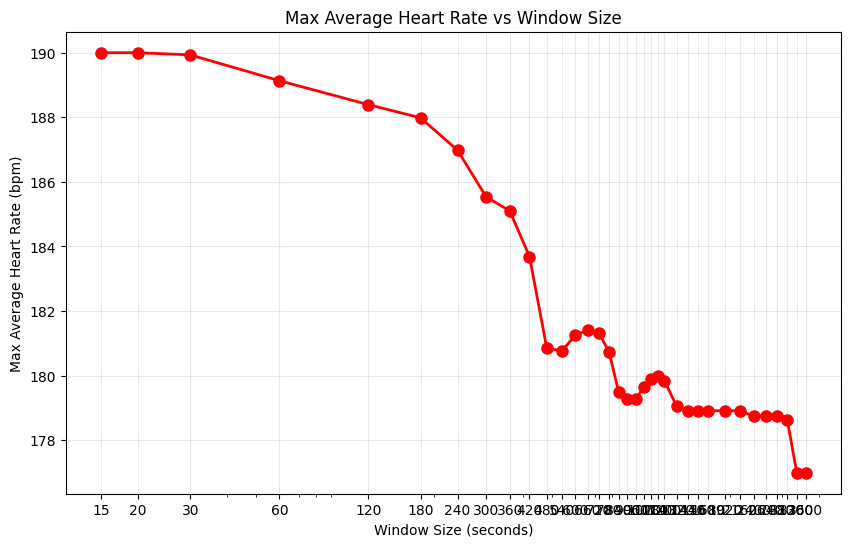

In [24]:

# Compute the heart rate profile
max_avg_hrs,_ = compute_profile(df_with_clusters, "hr",None, window_sizes)

# Optional: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(list(max_avg_hrs.keys()), list(max_avg_hrs.values()), 'o-', linewidth=2, markersize=8, color='red')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Max Average Heart Rate (bpm)')
plt.title('Max Average Heart Rate vs Window Size')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.xticks(window_sizes, labels=window_sizes)
plt.show()


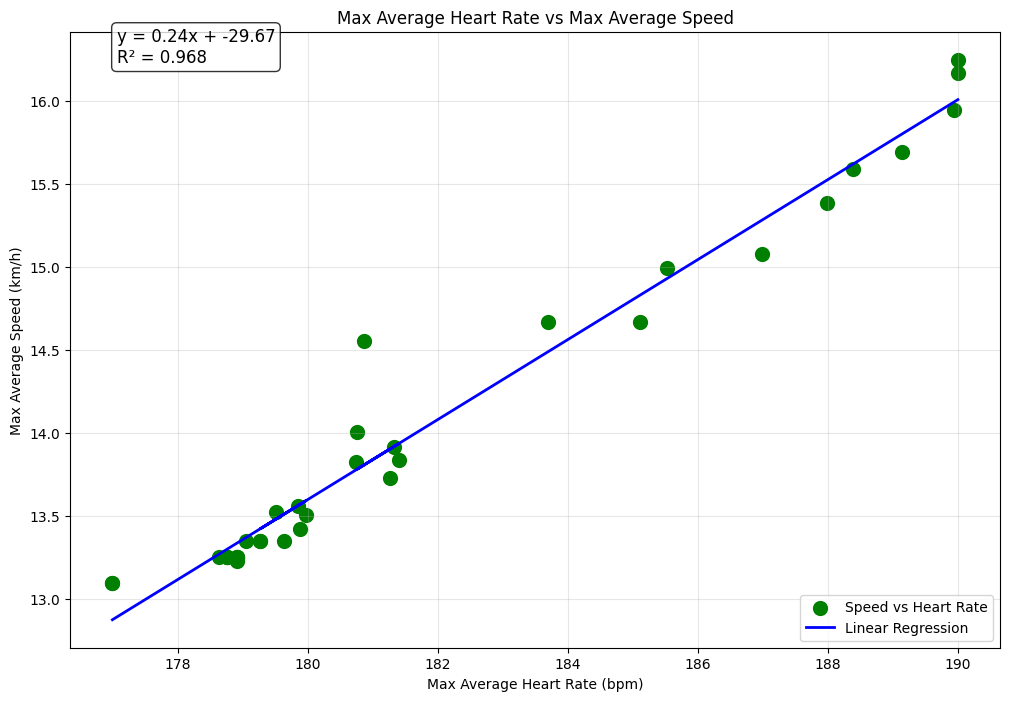

Heart Rate: 140 bpm, Speed: 4.0 km/h
Heart Rate: 150 bpm, Speed: 6.4 km/h
Heart Rate: 160 bpm, Speed: 8.8 km/h
Heart Rate: 170 bpm, Speed: 11.2 km/h
Heart Rate: 180 bpm, Speed: 13.6 km/h
Heart Rate: 185 bpm, Speed: 14.8 km/h
Heart Rate: 190 bpm, Speed: 16.0 km/h
Heart Rate: 195 bpm, Speed: 17.2 km/h
Heart Rate: 200 bpm, Speed: 18.4 km/h


In [25]:
# Plot max_avg_hr and speed together for comparison
plt.figure(figsize=(12, 8))

# Plot speed profile (x-axis)
plt.scatter( list(max_avg_hrs.values())   , list(max_avg_speeds.values()),
         linewidth=2, s=80, color='green', label='Speed vs Heart Rate')

# Add linear regression
y_values = list(max_avg_speeds.values())
x_values = list(max_avg_hrs.values())
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
regression_line = slope * np.array(x_values) + intercept
plt.plot(x_values, regression_line, color='blue', linewidth=2, label='Linear Regression')

# Add formula text and r-value
formula_text = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.3f}'
plt.annotate(formula_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.ylabel('Max Average Speed (km/h)')
plt.xlabel('Max Average Heart Rate (bpm)')
plt.title('Max Average Heart Rate vs Max Average Speed')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


hr_list= [140,150,160,170,180,185,190,195,200]
for hr in hr_list:
    speed = slope * hr + intercept
    print(f"Heart Rate: {hr} bpm, Speed: {speed:.1f} km/h")


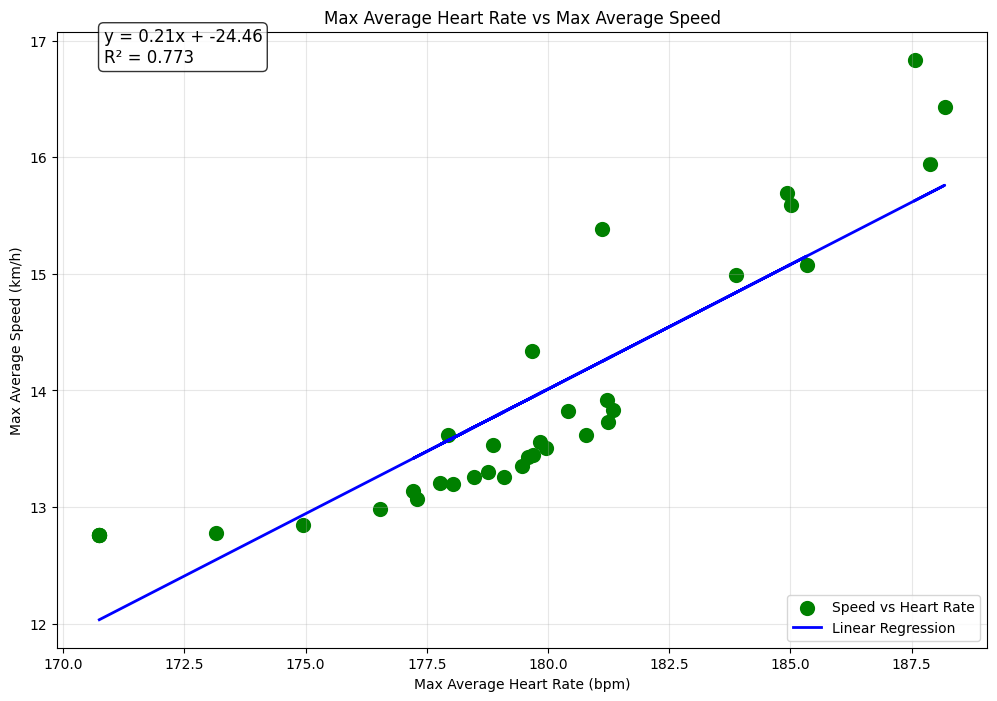

Heart Rate: 140 bpm, Speed: 5.5 km/h
Heart Rate: 150 bpm, Speed: 7.6 km/h
Heart Rate: 160 bpm, Speed: 9.7 km/h
Heart Rate: 170 bpm, Speed: 11.9 km/h
Heart Rate: 180 bpm, Speed: 14.0 km/h
Heart Rate: 185 bpm, Speed: 15.1 km/h
Heart Rate: 190 bpm, Speed: 16.1 km/h
Heart Rate: 195 bpm, Speed: 17.2 km/h
Heart Rate: 200 bpm, Speed: 18.3 km/h


In [13]:
# Plot max_avg_hr and speed together for comparison
plt.figure(figsize=(12, 8))

# Plot speed profile (x-axis)
plt.scatter( list(max_avg_additional_values.values())   , list(max_avg_speeds.values()),
         linewidth=2, s=80, color='green', label='Speed vs Heart Rate')

# Add linear regression
y_values = list(max_avg_speeds.values())
x_values = list(max_avg_additional_values.values())
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
regression_line = slope * np.array(x_values) + intercept
plt.plot(x_values, regression_line, color='blue', linewidth=2, label='Linear Regression')

# Add formula text and r-value
formula_text = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.3f}'
plt.annotate(formula_text, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.ylabel('Max Average Speed (km/h)')
plt.xlabel('Max Average Heart Rate (bpm)')
plt.title('Max Average Heart Rate vs Max Average Speed')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


hr_list= [140,150,160,170,180,185,190,195,200]
for hr in hr_list:
    speed = slope * hr + intercept
    print(f"Heart Rate: {hr} bpm, Speed: {speed:.1f} km/h")
